In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

# Section 1: DataFrame Loading, Cleaning

In [2]:
df_main = pd.read_csv('sgcarmart_used_cars_prices_dev_2.csv',index_col=0)
df_main.sample(5)

LISTING_URL   BRAND  \
5571  https://www.sgcarmart.com/used_cars/info.php?I...     BMW   
6042  https://www.sgcarmart.com/used_cars/info.php?I...  Subaru   
3482  https://www.sgcarmart.com/used_cars/info.php?I...    MINI   
6049  https://www.sgcarmart.com/used_cars/info.php?I...  Toyota   
3681  https://www.sgcarmart.com/used_cars/info.php?I...   Honda   

              MODEL_SUBMODEL     PRICE  DEPRE_VALUE_PER_YEAR     REG_DATE  \
5571             M Series M5  418800.0               41060.0  10-May-2019   
6042  Forester 2.0XT Sunroof   76888.0               12230.0  26-Aug-2016   
3482             Cooper 1.6A   36800.0               16300.0  11-Oct-2012   
6049      Wish 1.8A Elegance   60800.0               10450.0  03-Nov-2015   
3681              Fit 1.3A G   75800.0                7460.0  14-Oct-2020   

      MILEAGE_KM  MANUFACTURED_YEAR  ROAD_TAX_PER_YEAR TRANSMISSION  ...  \
5571     13988.0             2018.0             4568.0         Auto  ...   
6042     68700.0             2016.0             1210.0         Auto  ...   
3482         NaN             2012.0              742.0         Auto  ...   
6049     79826.0             2015.0              976.0         Auto  ...   
3681        72.0             2020.0              590.0         Auto  ...   

      SCRAPE_DATE     OMV       ARF  COE_LISTED  DAYS_OF_COE_LEFT  \
5571   18/03/2021  109165  168497.0     48010.0            2971.0   
6042   18/03/2021   20496   20695.0     57903.0            1982.0   
3482   18/03/2021   22597   22597.0     69000.0             567.0   
6049   18/03/2021   23454   24836.0     61300.0            1685.0   
3681   18/03/2021   18755    8755.0     36534.0            3490.0   

      ENGINE_CAPACITY_CC  POWER  CURB_WEIGHT_KG  NO_OF_OWNERS  VEHICLE_TYPE  
5571              4395.0  441.0          1855.0           1.0    Sports Car  
6042              1998.0  177.0          1682.0           1.0           SUV  
3482              1598.0   90.0          1105.0           1.0     Hatchback  
6049              1798.0  105.0          1360.0           1.0           MPV  
3681              1339.0   72.0             NaN           1.0     Hatchback  

[5 rows x 21 columns]

In [3]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6953 entries, 0 to 6952
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   LISTING_URL                   6953 non-null   object 
 1   BRAND                         6953 non-null   object 
 2   MODEL_SUBMODEL                6953 non-null   object 
 3   PRICE                         6922 non-null   float64
 4   DEPRE_VALUE_PER_YEAR          6795 non-null   float64
 5   REG_DATE                      6953 non-null   object 
 6   MILEAGE_KM                    6259 non-null   float64
 7   MANUFACTURED_YEAR             6938 non-null   float64
 8   ROAD_TAX_PER_YEAR             6881 non-null   float64
 9   TRANSMISSION                  6953 non-null   object 
 10  DEREG_VALUE_FROM_SCRAPE_DATE  6912 non-null   float64
 11  SCRAPE_DATE                   6953 non-null   object 
 12  OMV                           6953 non-null   int64  
 13  ARF

In [4]:
df_clean = df_main.copy()
df_clean.dropna(inplace = True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 6952
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   LISTING_URL                   5943 non-null   object 
 1   BRAND                         5943 non-null   object 
 2   MODEL_SUBMODEL                5943 non-null   object 
 3   PRICE                         5943 non-null   float64
 4   DEPRE_VALUE_PER_YEAR          5943 non-null   float64
 5   REG_DATE                      5943 non-null   object 
 6   MILEAGE_KM                    5943 non-null   float64
 7   MANUFACTURED_YEAR             5943 non-null   float64
 8   ROAD_TAX_PER_YEAR             5943 non-null   float64
 9   TRANSMISSION                  5943 non-null   object 
 10  DEREG_VALUE_FROM_SCRAPE_DATE  5943 non-null   float64
 11  SCRAPE_DATE                   5943 non-null   object 
 12  OMV                           5943 non-null   int64  
 13  ARF

# Section 2: Exploratory Data Analysis

### Section 2.1: Dropping Unwanted Columns

In [5]:
df_clean.drop(['LISTING_URL', 'DEPRE_VALUE_PER_YEAR', 'REG_DATE', 'MANUFACTURED_YEAR', 'ROAD_TAX_PER_YEAR', 'TRANSMISSION', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'SCRAPE_DATE', 'OMV', 'ENGINE_CAPACITY_CC', 'POWER', 'CURB_WEIGHT_KG', 'VEHICLE_TYPE'],axis=1, inplace = True) # Dropping columns

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 6952
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BRAND             5943 non-null   object 
 1   MODEL_SUBMODEL    5943 non-null   object 
 2   PRICE             5943 non-null   float64
 3   MILEAGE_KM        5943 non-null   float64
 4   ARF               5943 non-null   float64
 5   COE_LISTED        5943 non-null   float64
 6   DAYS_OF_COE_LEFT  5943 non-null   float64
 7   NO_OF_OWNERS      5943 non-null   float64
dtypes: float64(6), object(2)
memory usage: 417.9+ KB


#### Section 2.1.1: Dropping duplicated rows

In [6]:
df_clean[df_clean.duplicated(keep = False)]

BRAND             MODEL_SUBMODEL     PRICE  MILEAGE_KM      ARF  \
1006  Volkswagen     Golf 1.4A TSI Highline  109988.0      5000.0  27035.0   
1994         BMW  2 Series 216i Gran Tourer  101500.0     31200.0  34671.0   
2149  Volkswagen     Golf 1.4A TSI Highline  109988.0      5000.0  27035.0   
3378         BMW  2 Series 216i Gran Tourer  101500.0     31200.0  34671.0   
3565       Skoda  Octavia 1.4A TSI Ambition   94988.0      5000.0  18870.0   
4021       Skoda  Octavia 1.4A TSI Ambition   94988.0      5000.0  18870.0   

      COE_LISTED  DAYS_OF_COE_LEFT  NO_OF_OWNERS  
1006     38504.0            3506.0           1.0  
1994     36890.0            2654.0           1.0  
2149     38504.0            3506.0           1.0  
3378     36890.0            2654.0           1.0  
3565     41503.0            3536.0           1.0  
4021     41503.0            3536.0           1.0

In [7]:
df_clean.drop_duplicates(inplace = True)

In [8]:
# Taking a look at our data
df_clean.sample(10)

BRAND                            MODEL_SUBMODEL      PRICE  \
1172         Subaru                Impreza 4D 2.0i-S EyeSight    70800.0   
1953  Mercedes-Benz  C-Class C200 Coupe AMG Line Premium Plus   135800.0   
1220          Lexus                              NX300 Luxury   165800.0   
1389    Lamborghini             Aventador LP750-4 Superveloce  1170900.0   
5191  Mercedes-Benz      GL-Class GL350 BlueTEC CDI AMG Sport   183800.0   
5004        Ferrari                                   488 GTB   780000.0   
271       Ssangyong                   Stavic Diesel 2.0A eXDI    66900.0   
5445          Mazda                             3 1.5A Deluxe    56900.0   
2894           Audi               A6 1.8A TFSI Ultra S-tronic   110000.0   
3537        Bentley                          Bentayga 4.0A V8   708000.0   

      MILEAGE_KM       ARF  COE_LISTED  DAYS_OF_COE_LEFT  NO_OF_OWNERS  
1172     40600.0   14416.0     37010.0            2572.0           1.0  
1953     78000.0   50285.0     55501.0            2013.0           1.0  
1220     18000.0   58316.0     30851.0            2837.0           1.0  
1389      7300.0  831587.0     57501.0            1760.0           3.0  
5191     70036.0  117635.0     60001.0            1650.0           2.0  
5004     18000.0  512040.0     55501.0            2050.0           2.0  
271      95300.0   28710.0     58190.0            1666.0           2.0  
5445    109860.0   13819.0     51507.0            2037.0           1.0  
2894     43000.0   43846.0     48209.0            2160.0           1.0  
3537     13500.0  314535.0     34989.0            3424.0           1.0

In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5940 entries, 0 to 6952
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BRAND             5940 non-null   object 
 1   MODEL_SUBMODEL    5940 non-null   object 
 2   PRICE             5940 non-null   float64
 3   MILEAGE_KM        5940 non-null   float64
 4   ARF               5940 non-null   float64
 5   COE_LISTED        5940 non-null   float64
 6   DAYS_OF_COE_LEFT  5940 non-null   float64
 7   NO_OF_OWNERS      5940 non-null   float64
dtypes: float64(6), object(2)
memory usage: 417.7+ KB


In [10]:
print(df_clean.columns,'\n',len(df_clean.columns))



Index(['BRAND', 'MODEL_SUBMODEL', 'PRICE', 'MILEAGE_KM', 'ARF', 'COE_LISTED',
       'DAYS_OF_COE_LEFT', 'NO_OF_OWNERS'],
      dtype='object') 
 8


#### Section 2.1.2: Inspecting Variable Counts for Abnormilites

array([[<AxesSubplot:title={'center':'PRICE'}>,
        <AxesSubplot:title={'center':'MILEAGE_KM'}>,
        <AxesSubplot:title={'center':'ARF'}>,
        <AxesSubplot:title={'center':'COE_LISTED'}>],
       [<AxesSubplot:title={'center':'DAYS_OF_COE_LEFT'}>,
        <AxesSubplot:title={'center':'NO_OF_OWNERS'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

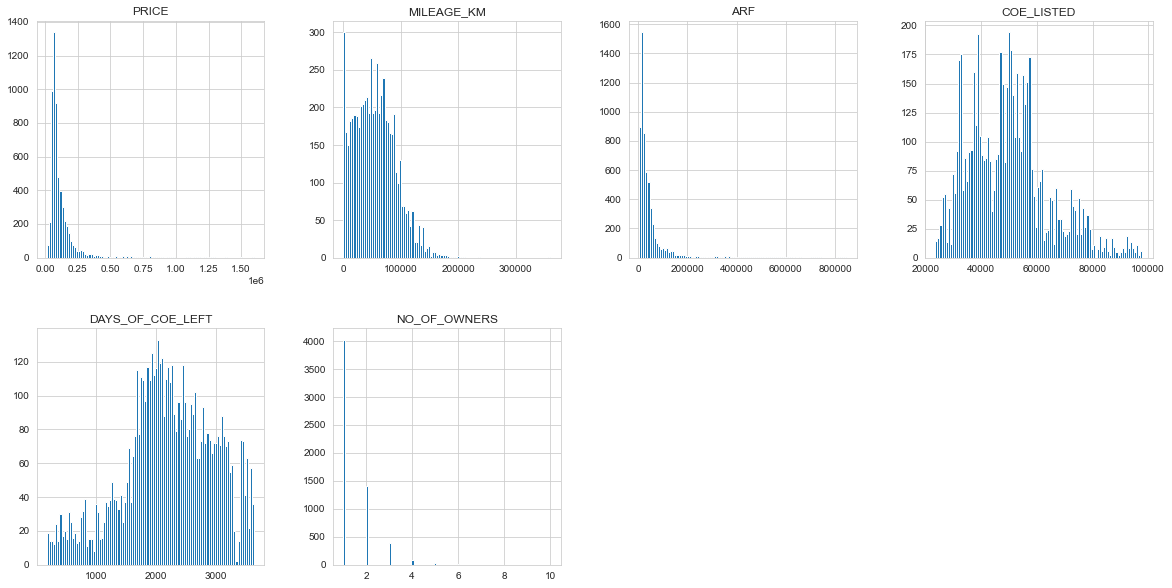

In [11]:
df_clean.hist(bins =100,layout=(2,4), figsize = (20,10))

In [12]:
df_clean['MILEAGE_KM'].sort_values(ascending=False)

6776    360000.0
1661    234800.0
2227    212000.0
5582    203000.0
5935    200000.0
          ...   
2785         8.0
630          8.0
5140         8.0
4157         8.0
3323         5.0
Name: MILEAGE_KM, Length: 5940, dtype: float64

<AxesSubplot:xlabel='MILEAGE_KM', ylabel='PRICE'>

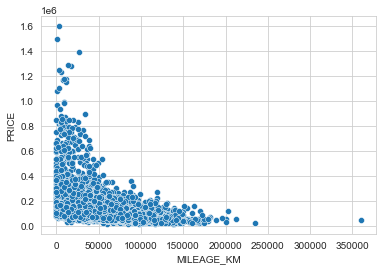

In [13]:
sns.scatterplot(x= df_clean['MILEAGE_KM'], y= df_clean['PRICE'])


In [14]:
df_clean.loc[6776]

BRAND                      Honda
MODEL_SUBMODEL      City 1.5A SV
PRICE                      48800
MILEAGE_KM                360000
ARF                        12797
COE_LISTED                 58700
DAYS_OF_COE_LEFT            1610
NO_OF_OWNERS                   1
Name: 6776, dtype: object

In [15]:
df_clean['ARF'].describe()

count      5940.000000
mean      47698.860774
std       70540.954185
min        5000.000000
25%       16544.000000
50%       26655.500000
75%       48056.750000
max      844293.000000
Name: ARF, dtype: float64

<AxesSubplot:xlabel='ARF', ylabel='PRICE'>

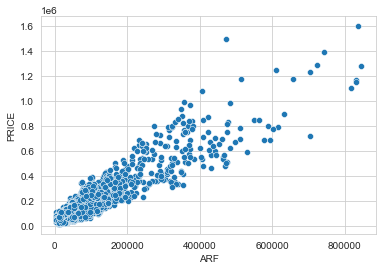

In [16]:
sns.scatterplot(x= df_clean['ARF'], y= df_clean['PRICE'])

In [17]:
df_clean['PRICE'].describe()

count    5.940000e+03
mean     1.192663e+05
std      1.179707e+05
min      1.480000e+04
25%      6.480000e+04
50%      8.290000e+04
75%      1.278000e+05
max      1.598888e+06
Name: PRICE, dtype: float64

In [18]:
# from scipy import stats
# df_clean = df_clean[(np.abs(stats.zscore(df_clean[['PRICE']])) < float(6)).all(axis=1)]

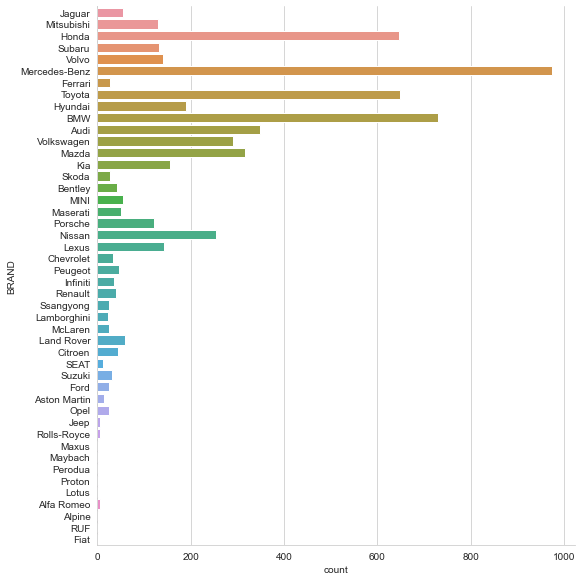

In [19]:
sns.catplot(y="BRAND", kind="count", data= df_clean, height = 8);

### Section 2.2: Preliminary Correlation Exploration

<ipython-input-20-00656ab2176c>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df_clean.corr(), dtype=np.bool)


(6.5, -0.5)

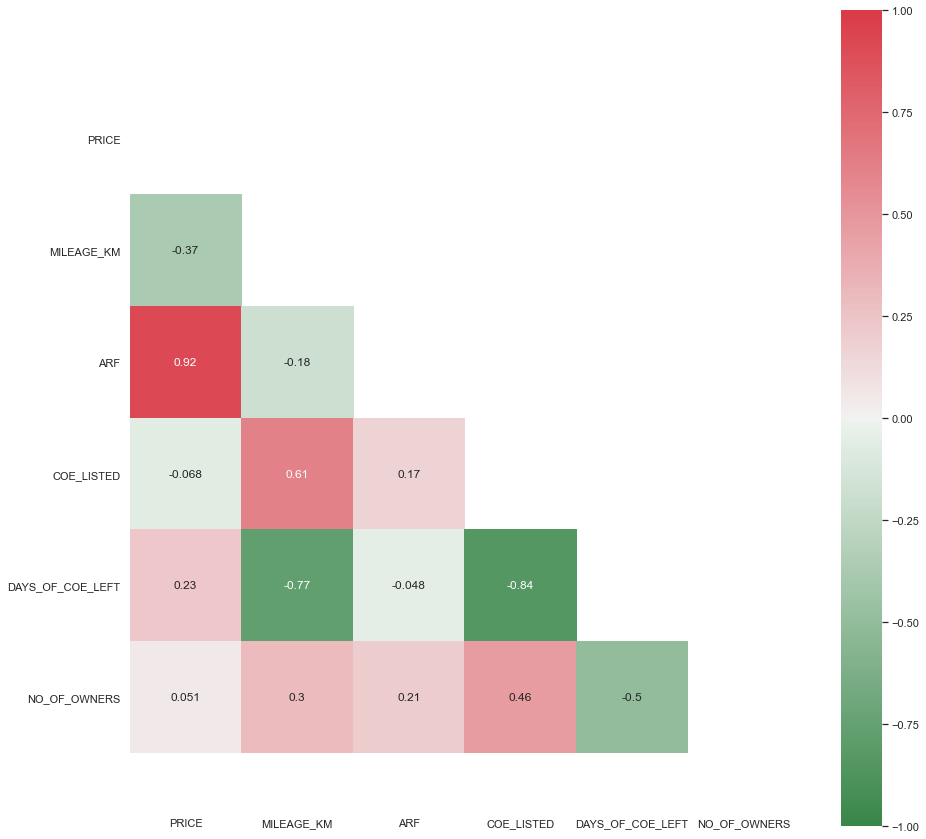

In [20]:
# Corr Matrix Heatmap Visualization

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(df_clean.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(15,15))

# Create a custom color palette
cmap = \
sns.diverging_palette(133, 10,
                      as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Green = Good (low correlation), Red = Bad (high correlation) between the independent variables

# Plot the heatmap
sns.heatmap(df_clean.corr(), mask=mask, annot=True, 
            square=True, cmap=cmap , vmin=-1, vmax=1,ax=ax);

# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [21]:
# Correlations of the independent variables (features) to dependent variable (target, price)
df_clean.corr()['PRICE'].sort_values(ascending=False)

PRICE               1.000000
ARF                 0.919446
DAYS_OF_COE_LEFT    0.232910
NO_OF_OWNERS        0.051341
COE_LISTED         -0.068123
MILEAGE_KM         -0.374145
Name: PRICE, dtype: float64

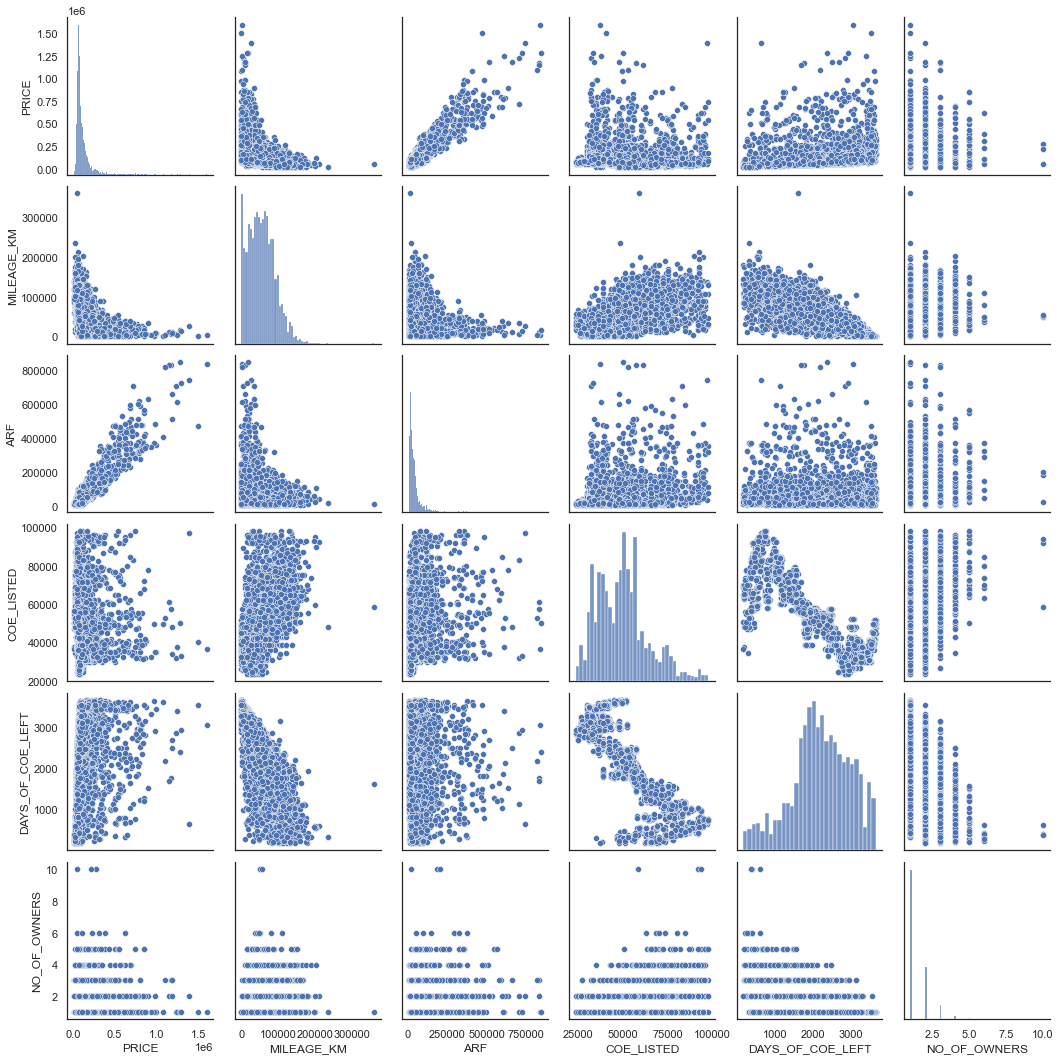

In [22]:
# Performing a pairplot to visualize the data trends of the variables


sns.pairplot(df_clean);

In [23]:
df_clean.columns

Index(['BRAND', 'MODEL_SUBMODEL', 'PRICE', 'MILEAGE_KM', 'ARF', 'COE_LISTED',
       'DAYS_OF_COE_LEFT', 'NO_OF_OWNERS'],
      dtype='object')

## Section 2.3: Analysis of Car Brands, Model, Sub-Model

In [24]:
df_value_counts = pd.DataFrame(df_clean['BRAND'].value_counts())
df_value_counts = df_value_counts.reset_index().set_axis(['BRAND','COUNTS'], axis=1)
df_value_counts

BRAND  COUNTS
0   Mercedes-Benz     974
1             BMW     729
2          Toyota     648
3           Honda     646
4            Audi     349
5           Mazda     316
6      Volkswagen     291
7          Nissan     255
8         Hyundai     191
9             Kia     155
10          Lexus     143
11          Volvo     140
12         Subaru     133
13     Mitsubishi     129
14        Porsche     121
15     Land Rover      60
16         Jaguar      56
17           MINI      55
18       Maserati      51
19        Peugeot      46
20        Citroen      44
21        Bentley      42
22        Renault      39
23       Infiniti      35
24      Chevrolet      34
25         Suzuki      31
26        Ferrari      27
27          Skoda      27
28           Opel      25
29      Ssangyong      24
30        McLaren      24
31           Ford      24
32    Lamborghini      23
33   Aston Martin      15
34           SEAT      13
35           Jeep       6
36    Rolls-Royce       6
37     Alfa Romeo       5
38          Lotus       1
39         Proton       1
40         Alpine       1
41          Maxus       1
42            RUF       1
43        Perodua       1
44        Maybach       1
45           Fiat       1

In [25]:
brand_list = df_clean['BRAND'].sort_values().unique().tolist()
brand_list

['Alfa Romeo',
 'Alpine',
 'Aston Martin',
 'Audi',
 'BMW',
 'Bentley',
 'Chevrolet',
 'Citroen',
 'Ferrari',
 'Fiat',
 'Ford',
 'Honda',
 'Hyundai',
 'Infiniti',
 'Jaguar',
 'Jeep',
 'Kia',
 'Lamborghini',
 'Land Rover',
 'Lexus',
 'Lotus',
 'MINI',
 'Maserati',
 'Maxus',
 'Maybach',
 'Mazda',
 'McLaren',
 'Mercedes-Benz',
 'Mitsubishi',
 'Nissan',
 'Opel',
 'Perodua',
 'Peugeot',
 'Porsche',
 'Proton',
 'RUF',
 'Renault',
 'Rolls-Royce',
 'SEAT',
 'Skoda',
 'Ssangyong',
 'Subaru',
 'Suzuki',
 'Toyota',
 'Volkswagen',
 'Volvo']

In [26]:
import pickle
# dump brand list for api wrapper webservice app
pickle.dump(brand_list,open('brand_list_v4.pkl','wb'))

In [27]:
df_clean['MODEL_SUBMODEL'].value_counts()

Vezel 1.5A X                                  102
Civic 1.6A VTi                                 69
C-Class C180 Avantgarde                        68
Corolla Altis 1.6A Elegance                    54
5 2.0A Sunroof                                 50
                                             ... 
Corolla Hatchback Hybrid 1.8A Ascent Sport      1
Biante 2.0A Deluxe                              1
GLC-Class GLC200 Coupe AMG                      1
Odyssey 2.4A G                                  1
Corolla Axio Hybrid 1.5A G                      1
Name: MODEL_SUBMODEL, Length: 1446, dtype: int64

In [28]:
modelsubmodel_db = {}
for brand in brand_list:
    modelsubmodel_db[brand] = df_clean[df_clean['BRAND']== brand]['MODEL_SUBMODEL'].sort_values().unique().tolist()

In [29]:
modelsubmodel_db

{'Alfa Romeo': ['Giulia 2.0A Veloce',
  'Giulia 2.9A Quadrifoglio',
  'Giulietta 1.4A Turbo',
  'Giulietta 1.8A QV',
  'Stelvio 2.9A Quadrifoglio'],
 'Alpine': ['A110 1.8A Pure'],
 'Aston Martin': ['DB11 V12 5.2A',
  'DB11 V8 4.0A',
  'DBS Superleggera',
  'Rapide S 6.0A',
  'V8 Vantage N430 Coupe Sportshift II',
  'V8 Vantage Roadster 4.7A Sportshift II',
  'V8 Vantage S Coupe 4.7A',
  'V8 Vantage S Roadster 4.7A Sportshift II',
  'Vanquish 6.0A',
  'Vantage 4.0A'],
 'Audi': ['A1 Sportback 1.0A TFSI S-tronic',
  'A1 Sportback 1.0A TFSI S-tronic S-Line',
  'A3 Cabriolet 1.4A TFSI S-tronic',
  'A3 Sedan 1.0A TFSI S-tronic',
  'A3 Sedan 1.4A TFSI Ambiente',
  'A3 Sedan 1.4A TFSI Attraction',
  'A3 Sedan 1.4A TFSI CoD S-tronic',
  'A3 Sedan 1.4A TFSI S-tronic',
  'A3 Sedan 1.4A TFSI S-tronic Ambiente',
  'A3 Sedan 1.4A TFSI S-tronic Attraction',
  'A3 Sportback 1.0A TFSI S-tronic',
  'A3 Sportback 1.4A TFSI Attraction',
  'A3 Sportback 1.4A TFSI S-tronic Ambiente',
  'A3 Sportback 1.4A TF

In [30]:
import pickle
# dump model-submodel list for api wrapper webservice app
pickle.dump(modelsubmodel_db,open('modelsubmodel_db_v4.pkl','wb'))

In [31]:
df_clean

BRAND                       MODEL_SUBMODEL     PRICE  \
0            Jaguar              XE Diesel 2.0A Prestige   94999.0   
1        Mitsubishi                       Lancer EX 1.6A   52800.0   
2             Honda  Odyssey 2.4A EXV-S Navi Res Sunroof   73500.0   
3             Honda                         Vezel 1.5A X   89800.0   
4            Subaru               Forester 2.0XT Sunroof   72800.0   
...             ...                                  ...       ...   
6947           Opel                     Astra 1.4A Turbo   61800.0   
6948         Toyota                  Camry Hybrid 2.5A G  113800.0   
6949  Mercedes-Benz  C-Class C200 Mild Hybrid Avantgarde  168888.0   
6950          Honda           Vezel 1.5A X Honda Sensing   71800.0   
6952         Subaru     Forester 2.0i-S EyeSight Sunroof  108000.0   

      MILEAGE_KM      ARF  COE_LISTED  DAYS_OF_COE_LEFT  NO_OF_OWNERS  
0        45000.0  31850.0     46229.0            2089.0           3.0  
1        62316.0  13225.0     50101.0            2171.0           1.0  
2       147000.0  32750.0     59889.0            1688.0           1.0  
3        72000.0  10584.0     47020.0            1891.0           2.0  
4        76022.0  19146.0     47604.0            1837.0           1.0  
...          ...      ...         ...               ...           ...  
6947     62000.0  15700.0     53300.0            2257.0           1.0  
6948     13903.0  36714.0     42564.0            2992.0           1.0  
6949      4800.0  53152.0     41001.0            3143.0           1.0  
6950     41724.0  11630.0     42339.0            2469.0           1.0  
6952     25000.0  17902.0     38602.0            3084.0           1.0  

[5940 rows x 8 columns]

In [32]:
df_withdummies = df_clean.copy()

In [33]:
df_withdummies = pd.concat([df_withdummies,pd.get_dummies(df_withdummies['BRAND'])],axis=1).drop(['BRAND'],axis=1)
df_withdummies = pd.concat([df_withdummies,pd.get_dummies(df_withdummies['MODEL_SUBMODEL'])],axis=1).drop(['MODEL_SUBMODEL'],axis=1)


In [34]:
df_withdummies.shape

(5940, 1498)

## Section 3: Preliminary Model fitting to check R^2 Value and P>|t| values of Price and its Independent Variables

In [35]:
# model / fit / summarize
import statsmodels.api as sm
X = df_withdummies.drop(['PRICE'], axis = 1)
X = sm.add_constant(X)
y = df_withdummies['PRICE']

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     262.7
Date:                Thu, 25 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:35:02   Log-Likelihood:                -64573.
No. Observations:                5940   AIC:                         1.320e+05
Df Residuals:                    4489   BIC:                         1.418e+05
Df Model:                        1450                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                                     4.265e+04   4472.170      9.538      0.000    3.39e+04    5.14e+04
MILEAGE_KM                                                   0.0037      0.011      0.333      0.739      -0.018       0.025
ARF                                                          0.8643      0.026     33.678      0.000       0.814       0.915
COE_LISTED                                                   0.0147      0.036      0.410      0.682      -0.056       0.085
DAYS_OF_COE_LEFT                                            37.3515      0.888     42.069      0.000      35.611      39.092
NO_OF_OWNERS                                             -2513.6588    388.487     -6.470      0.000   -3275.284   -1752.034
Alfa Romeo                                               -2989.3483   5481.146     -0.545      0.586   -1.37e+04    7756.398
Alpine                                                    -572.2424   7267.108     -0.079      0.937   -1.48e+04    1.37e+04
Aston Martin                                              1.128e+05   6090.936     18.521      0.000    1.01e+05    1.25e+05
Audi                                                     -2.757e+04   1758.418    -15.682      0.000    -3.1e+04   -2.41e+04
BMW                                                      -2.295e+04   1283.062    -17.888      0.000   -2.55e+04   -2.04e+04
Bentley                                                   1.328e+05   7017.419     18.925      0.000    1.19e+05    1.47e+05
Chevrolet                                                -6.468e+04   4069.092    -15.896      0.000   -7.27e+04   -5.67e+04
Citroen                                                  -6.752e+04   3371.139    -20.027      0.000   -7.41e+04   -6.09e+04
Ferrari                                                   1.949e+05   8917.981     21.851      0.000    1.77e+05    2.12e+05
Fiat                                                     -2436.0146   7469.256     -0.326      0.744   -1.71e+04    1.22e+04
Ford                                                     -3.231e+04   3423.276     -9.438      0.000    -3.9e+04   -2.56e+04
Honda                                                    -6.467e+04   2495.859    -25.911      0.000   -6.96e+04   -5.98e+04
Hyundai                                                  -6.668e+04   2828.758    -23.573      0.000   -7.22e+04   -6.11e+04
Infiniti                                                 -4.869e+04   3197.335    -15.229      0.000    -5.5e+04   -4.24e+04
Jaguar                                                   -3.788e+04   2401.952    -15.771      0.000   -4.26e+04   -3.32e+04
Jeep                                                     -3.628e+04   5224.693     

### Section 3.1: Optimizing R^2 Value

##### Histograph of all Variables (Columns) in DataFrame

<ipython-input-36-2447d437866a>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.DataFrame.hist(df_clean,ax=ax)


array([[<AxesSubplot:title={'center':'PRICE'}>,
        <AxesSubplot:title={'center':'MILEAGE_KM'}>],
       [<AxesSubplot:title={'center':'ARF'}>,
        <AxesSubplot:title={'center':'COE_LISTED'}>],
       [<AxesSubplot:title={'center':'DAYS_OF_COE_LEFT'}>,
        <AxesSubplot:title={'center':'NO_OF_OWNERS'}>]], dtype=object)

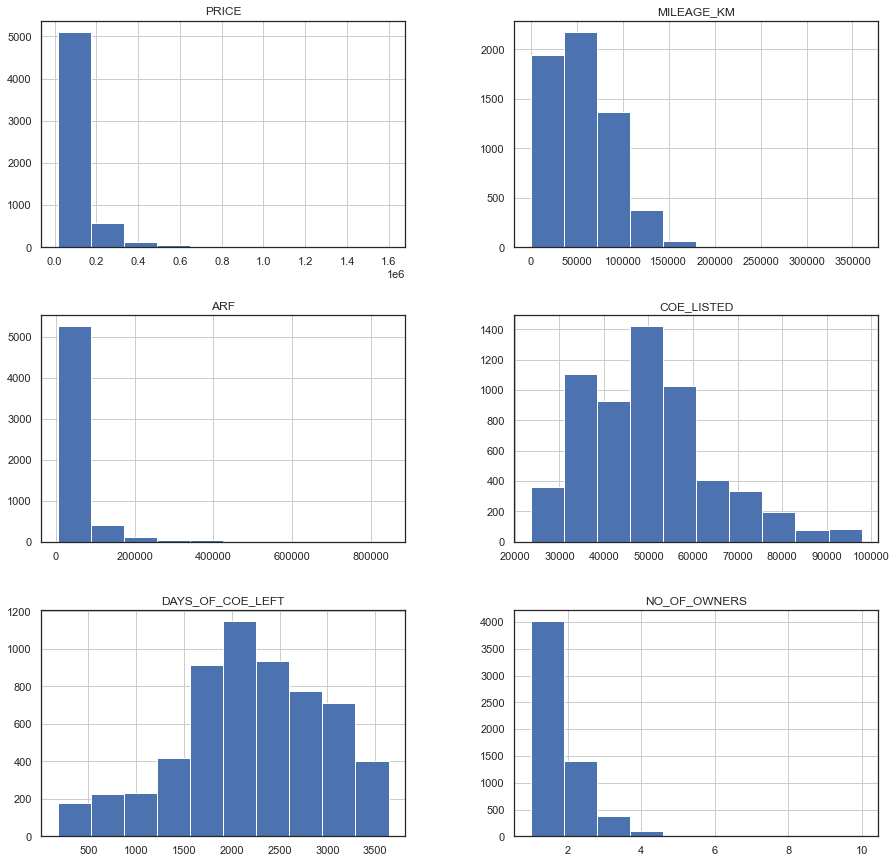

In [36]:
fig, ax = plt.subplots(figsize=(15,15))
pd.DataFrame.hist(df_clean,ax=ax)

In [37]:
# From the above graphs, it would make sense to apply log transform on the following variables to make them
# more normally distributed
# PRICE
# MILEAGE
# ARF


#### Distribution of Price

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PRICE'>

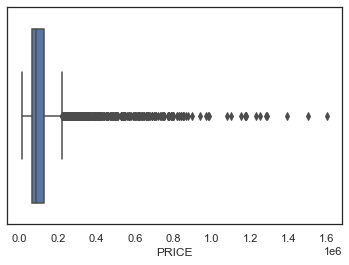

In [38]:
sns.boxplot(df_clean['PRICE']) 

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PRICE', ylabel='Density'>

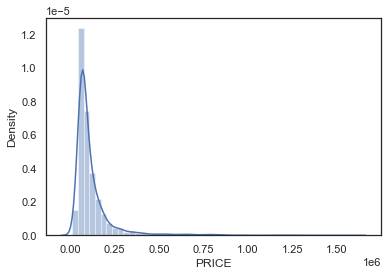

In [39]:
sns.distplot(df_clean['PRICE'])  # Your dependent variable 'must' be normally distributed

In [40]:
# We see that price is right-skewed. Therefore, we can try applying a log onto price, then visualize the data again.

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'PRICE')

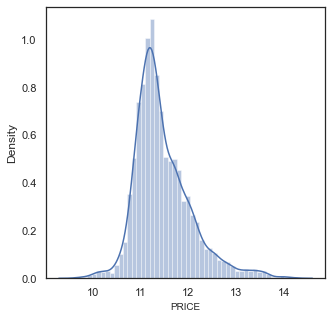

In [41]:
fig, ax = plt.subplots(figsize=(5,5))
sns.distplot(np.log(df_clean['PRICE']),ax=ax)
plt.xlabel('PRICE',size=10)
# plt.savefig("price_no_log.png",transparent=True)

### Section 3.1.1: Logging Mileage ONLY

In [42]:
# Creating a copy of the dataframe to work log on
df_withdummies_only_mileage_logged = df_withdummies.copy()

In [43]:
# Log Mileage
df_withdummies_only_mileage_logged["MILEAGE_LOG"] = df_withdummies['MILEAGE_KM'].apply(np.log)
df_withdummies_only_mileage_logged.drop(['MILEAGE_KM'], axis = 1, inplace = True)

In [44]:
# Rearrange columns
cols = list(df_withdummies_only_mileage_logged.columns)
cols = [cols[-1]] + cols[:-1]
df_withdummies_only_mileage_logged = df_withdummies_only_mileage_logged[cols]

In [45]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_withdummies_only_mileage_logged.drop(['PRICE'], axis = 1)
X = sm.add_constant(X)
y = df_withdummies_only_mileage_logged['PRICE']


# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     263.7
Date:                Thu, 25 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:35:12   Log-Likelihood:                -64561.
No. Observations:                5940   AIC:                         1.320e+05
Df Residuals:                    4489   BIC:                         1.417e+05
Df Model:                        1450                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                                     6.052e+04   5902.983     10.252      0.000    4.89e+04    7.21e+04
MILEAGE_LOG                                              -1201.3467    282.098     -4.259      0.000   -1754.397    -648.296
ARF                                                          0.8615      0.026     33.626      0.000       0.811       0.912
COE_LISTED                                                  -0.0122      0.036     -0.336      0.737      -0.084       0.059
DAYS_OF_COE_LEFT                                            35.4328      0.886     40.001      0.000      33.696      37.169
NO_OF_OWNERS                                             -2506.0635    387.589     -6.466      0.000   -3265.929   -1746.198
Alfa Romeo                                               -2497.0766   5470.987     -0.456      0.648   -1.32e+04    8228.754
Alpine                                                     212.0527   7254.393      0.029      0.977    -1.4e+04    1.44e+04
Aston Martin                                              1.133e+05   6073.293     18.656      0.000    1.01e+05    1.25e+05
Audi                                                     -2.705e+04   1754.583    -15.418      0.000   -3.05e+04   -2.36e+04
BMW                                                      -2.236e+04   1283.032    -17.425      0.000   -2.49e+04   -1.98e+04
Bentley                                                   1.331e+05   6997.516     19.025      0.000    1.19e+05    1.47e+05
Chevrolet                                                -6.385e+04   4056.386    -15.742      0.000   -7.18e+04   -5.59e+04
Citroen                                                  -6.654e+04   3359.157    -19.809      0.000   -7.31e+04      -6e+04
Ferrari                                                   1.948e+05   8880.148     21.942      0.000    1.77e+05    2.12e+05
Fiat                                                     -3562.1299   7450.236     -0.478      0.633   -1.82e+04     1.1e+04
Ford                                                      -3.21e+04   3414.846     -9.400      0.000   -3.88e+04   -2.54e+04
Honda                                                    -6.432e+04   2486.646    -25.867      0.000   -6.92e+04   -5.94e+04
Hyundai                                                   -6.61e+04   2818.858    -23.448      0.000   -7.16e+04   -6.06e+04
Infiniti                                                 -4.775e+04   3193.182    -14.953      0.000    -5.4e+04   -4.15e+04
Jaguar                                                    -3.71e+04   2401.375    -15.451      0.000   -4.18e+04   -3.24e+04
Jeep                                                     -3.595e+04   5214.191     

### Section 3.1.2: Logged Price with Logged Mileage only

In [46]:
df_withdummies_mileage_logged_price_logged = df_withdummies_only_mileage_logged.copy()

In [47]:
# Logging Price
df_withdummies_mileage_logged_price_logged['PRICE_LOG'] = df_withdummies_mileage_logged_price_logged['PRICE'].apply(np.log)

# drop PRICE column
df_withdummies_mileage_logged_price_logged.drop(['PRICE'], axis =1, inplace=True)

In [48]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_withdummies_mileage_logged_price_logged.drop(['PRICE_LOG'], axis = 1)
X = sm.add_constant(X)
y = df_withdummies_mileage_logged_price_logged['PRICE_LOG']


# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PRICE_LOG   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     332.7
Date:                Thu, 25 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:35:19   Log-Likelihood:                 8581.5
No. Observations:                5940   AIC:                        -1.426e+04
Df Residuals:                    4489   BIC:                            -4555.
Df Model:                        1450                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                                       10.3858      0.027    391.790      0.000      10.334      10.438
MILEAGE_LOG                                                  0.0073      0.001      5.754      0.000       0.005       0.010
ARF                                                       1.321e-06   1.15e-07     11.480      0.000     1.1e-06    1.55e-06
COE_LISTED                                                6.115e-07   1.64e-07      3.739      0.000    2.91e-07    9.32e-07
DAYS_OF_COE_LEFT                                             0.0004   3.98e-06    102.695      0.000       0.000       0.000
NO_OF_OWNERS                                                -0.0114      0.002     -6.561      0.000      -0.015      -0.008
Alfa Romeo                                                   0.2724      0.025     11.086      0.000       0.224       0.321
Alpine                                                       0.2249      0.033      6.905      0.000       0.161       0.289
Aston Martin                                                 1.2129      0.027     44.473      0.000       1.159       1.266
Audi                                                         0.2984      0.008     37.871      0.000       0.283       0.314
BMW                                                          0.3775      0.006     65.519      0.000       0.366       0.389
Bentley                                                      1.3115      0.031     41.735      0.000       1.250       1.373
Chevrolet                                                   -0.3765      0.018    -20.669      0.000      -0.412      -0.341
Citroen                                                     -0.3170      0.015    -21.016      0.000      -0.347      -0.287
Ferrari                                                      1.5751      0.040     39.498      0.000       1.497       1.653
Fiat                                                         0.1027      0.033      3.069      0.002       0.037       0.168
Ford                                                        -0.0620      0.015     -4.041      0.000      -0.092      -0.032
Honda                                                       -0.2245      0.011    -20.109      0.000      -0.246      -0.203
Hyundai                                                     -0.3422      0.013    -27.030      0.000      -0.367      -0.317
Infiniti                                                     0.0521      0.014      3.632      0.000       0.024       0.080
Jaguar                                                       0.4211      0.011     39.049      0.000       0.400       0.442
Jeep                                                         0.1816      0.023     

### Section 3.1.3: Logged Price with Logged Mileage + Logged ARF

In [49]:
df_withdummies_mileage_logged_price_logged_arf_logged = df_withdummies_mileage_logged_price_logged.copy()

In [50]:
# Logging ARF
df_withdummies_mileage_logged_price_logged_arf_logged['ARF_LOG'] = df_withdummies_mileage_logged_price_logged_arf_logged['ARF'].apply(np.log)

# drop ARF column
df_withdummies_mileage_logged_price_logged_arf_logged.drop(['ARF'], axis =1, inplace=True)

In [51]:
# Rearrange columns
cols = list(df_withdummies_mileage_logged_price_logged_arf_logged.columns)
cols = [cols[-1]] + cols[:-1]
df_withdummies_mileage_logged_price_logged_arf_logged = df_withdummies_mileage_logged_price_logged_arf_logged[cols]

In [52]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_withdummies_mileage_logged_price_logged_arf_logged.drop(['PRICE_LOG'], axis = 1)
X = sm.add_constant(X)
y = df_withdummies_mileage_logged_price_logged_arf_logged['PRICE_LOG']


# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PRICE_LOG   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     331.0
Date:                Thu, 25 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:35:26   Log-Likelihood:                 8566.8
No. Observations:                5940   AIC:                        -1.423e+04
Df Residuals:                    4489   BIC:                            -4525.
Df Model:                        1450                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                                        9.8296      0.071    138.762      0.000       9.691       9.968
ARF_LOG                                                      0.0656      0.006     10.439      0.000       0.053       0.078
MILEAGE_LOG                                                  0.0073      0.001      5.723      0.000       0.005       0.010
COE_LISTED                                                7.822e-07   1.67e-07      4.686      0.000    4.55e-07    1.11e-06
DAYS_OF_COE_LEFT                                             0.0004      4e-06    102.083      0.000       0.000       0.000
NO_OF_OWNERS                                                -0.0119      0.002     -6.794      0.000      -0.015      -0.008
Alfa Romeo                                                   0.2042      0.024      8.437      0.000       0.157       0.252
Alpine                                                       0.1794      0.033      5.500      0.000       0.115       0.243
Aston Martin                                                 1.3347      0.020     65.183      0.000       1.295       1.375
Audi                                                         0.2180      0.007     32.672      0.000       0.205       0.231
BMW                                                          0.2980      0.006     48.336      0.000       0.286       0.310
Bentley                                                      1.4959      0.019     79.420      0.000       1.459       1.533
Chevrolet                                                   -0.4347      0.017    -26.269      0.000      -0.467      -0.402
Citroen                                                     -0.3785      0.013    -29.640      0.000      -0.404      -0.353
Ferrari                                                      1.8417      0.021     87.993      0.000       1.801       1.883
Fiat                                                         0.0637      0.033      1.911      0.056      -0.002       0.129
Ford                                                        -0.1310      0.014     -9.599      0.000      -0.158      -0.104
Honda                                                       -0.2852      0.008    -37.880      0.000      -0.300      -0.270
Hyundai                                                     -0.4038      0.010    -42.484      0.000      -0.422      -0.385
Infiniti                                                    -0.0309      0.013     -2.439      0.015      -0.056      -0.006
Jaguar                                                       0.3427      0.012     28.965      0.000       0.319       0.366
Jeep                                                         0.1096      0.023     

### Section 3.1.4: Logged Price with Logged ARF

In [53]:
df_withdummies_price_logged_arf_logged = df_withdummies.copy()

In [54]:
# Logging ARF
df_withdummies_price_logged_arf_logged['ARF_LOG'] = df_withdummies_price_logged_arf_logged['ARF'].apply(np.log)

# drop ARF column
df_withdummies_price_logged_arf_logged.drop(['ARF'], axis =1, inplace=True)

# Rearrange columns
cols = list(df_withdummies_price_logged_arf_logged.columns)
cols = [cols[-1]] + cols[:-1]
df_withdummies_price_logged_arf_logged = df_withdummies_price_logged_arf_logged[cols]

In [55]:
# Logging PRICE
df_withdummies_price_logged_arf_logged['PRICE_LOG'] = df_withdummies_price_logged_arf_logged['PRICE'].apply(np.log)

# drop PRICE column
df_withdummies_price_logged_arf_logged.drop(['PRICE'], axis =1, inplace=True)

# Rearrange columns
cols = list(df_withdummies_price_logged_arf_logged.columns)
cols = [cols[-1]] + cols[:-1]
df_withdummies_price_logged_arf_logged = df_withdummies_price_logged_arf_logged[cols]

In [56]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_withdummies_price_logged_arf_logged.drop(['PRICE_LOG'], axis = 1)
X = sm.add_constant(X)
y = df_withdummies_price_logged_arf_logged['PRICE_LOG']


# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PRICE_LOG   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     333.6
Date:                Thu, 25 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:35:33   Log-Likelihood:                 8590.2
No. Observations:                5940   AIC:                        -1.428e+04
Df Residuals:                    4489   BIC:                            -4572.
Df Model:                        1450                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                                       10.0020      0.068    146.935      0.000       9.869      10.135
ARF_LOG                                                      0.0639      0.006     10.214      0.000       0.052       0.076
MILEAGE_KM                                               -4.063e-07   4.91e-08     -8.272      0.000   -5.03e-07    -3.1e-07
COE_LISTED                                                6.097e-07   1.64e-07      3.724      0.000    2.89e-07    9.31e-07
DAYS_OF_COE_LEFT                                             0.0004   3.98e-06     95.998      0.000       0.000       0.000
NO_OF_OWNERS                                                -0.0115      0.002     -6.598      0.000      -0.015      -0.008
Alfa Romeo                                                   0.2098      0.024      8.705      0.000       0.163       0.257
Alpine                                                       0.1873      0.032      5.766      0.000       0.124       0.251
Aston Martin                                                 1.3298      0.020     65.154      0.000       1.290       1.370
Audi                                                         0.2261      0.007     34.127      0.000       0.213       0.239
BMW                                                          0.3064      0.006     50.166      0.000       0.294       0.318
Bentley                                                      1.4897      0.019     79.334      0.000       1.453       1.527
Chevrolet                                                   -0.4213      0.016    -25.552      0.000      -0.454      -0.389
Citroen                                                     -0.3635      0.013    -28.574      0.000      -0.388      -0.339
Ferrari                                                      1.8232      0.021     87.076      0.000       1.782       1.864
Fiat                                                         0.0449      0.033      1.352      0.177      -0.020       0.110
Ford                                                        -0.1259      0.014     -9.258      0.000      -0.153      -0.099
Honda                                                       -0.2783      0.008    -37.074      0.000      -0.293      -0.264
Hyundai                                                     -0.3942      0.009    -41.629      0.000      -0.413      -0.376
Infiniti                                                    -0.0188      0.013     -1.493      0.136      -0.043       0.006
Jaguar                                                       0.3525      0.012     29.986      0.000       0.329       0.375
Jeep                                                         0.1092      0.023     

### Section 3.1.5: Logged Price ONLY

In [57]:
df_withdummies_price_logged_only = df_withdummies.copy()

In [58]:
# Logging PRICE
df_withdummies_price_logged_only['PRICE_LOG'] = df_withdummies_price_logged_only['PRICE'].apply(np.log)

# drop PRICE column
df_withdummies_price_logged_only.drop(['PRICE'], axis =1, inplace=True)

# Rearrange columns
cols = list(df_withdummies_price_logged_only.columns)
cols = [cols[-1]] + cols[:-1]
df_withdummies_price_logged_only = df_withdummies_price_logged_only[cols]

In [59]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_withdummies_price_logged_only.drop(['PRICE_LOG'], axis = 1)
X = sm.add_constant(X)
y = df_withdummies_price_logged_only['PRICE_LOG']


# model / fit / summarize
import statsmodels.api as sm

lsm = sm.OLS(y, X)
results = lsm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PRICE_LOG   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     335.7
Date:                Thu, 25 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:35:40   Log-Likelihood:                 8608.1
No. Observations:                5940   AIC:                        -1.431e+04
Df Residuals:                    4489   BIC:                            -4608.
Df Model:                        1450                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                                       10.5431      0.020    528.377      0.000      10.504      10.582
MILEAGE_KM                                               -4.205e-07    4.9e-08     -8.586      0.000   -5.17e-07   -3.24e-07
ARF                                                       1.316e-06   1.15e-07     11.494      0.000    1.09e-06    1.54e-06
COE_LISTED                                                4.473e-07    1.6e-07      2.789      0.005    1.33e-07    7.62e-07
DAYS_OF_COE_LEFT                                             0.0004   3.96e-06     96.344      0.000       0.000       0.000
NO_OF_OWNERS                                                -0.0110      0.002     -6.359      0.000      -0.014      -0.008
Alfa Romeo                                                   0.2775      0.024     11.346      0.000       0.230       0.325
Alpine                                                       0.2323      0.032      7.166      0.000       0.169       0.296
Aston Martin                                                 1.2053      0.027     44.351      0.000       1.152       1.259
Audi                                                         0.3059      0.008     38.987      0.000       0.290       0.321
BMW                                                          0.3849      0.006     67.230      0.000       0.374       0.396
Bentley                                                      1.3024      0.031     41.598      0.000       1.241       1.364
Chevrolet                                                   -0.3621      0.018    -19.943      0.000      -0.398      -0.326
Citroen                                                     -0.3009      0.015    -20.008      0.000      -0.330      -0.271
Ferrari                                                      1.5533      0.040     39.036      0.000       1.475       1.631
Fiat                                                         0.0834      0.033      2.502      0.012       0.018       0.149
Ford                                                        -0.0566      0.015     -3.709      0.000      -0.087      -0.027
Honda                                                       -0.2166      0.011    -19.449      0.000      -0.238      -0.195
Hyundai                                                     -0.3315      0.013    -26.261      0.000      -0.356      -0.307
Infiniti                                                     0.0640      0.014      4.487      0.000       0.036       0.092
Jaguar                                                       0.4295      0.011     40.080      0.000       0.409       0.451
Jeep                                                         0.1805      0.023     

### R^2 Summary from Linear Regression Models
Price vs Original Independent Variables:  
R^2: **0.988**  
R^2 Adjusted: **0.985**  
df_withdummies
  
Price vs Independent Variables (Logged Mileage):  
R^2: **0.988**  
R^2 Adjusted: **0.985**  
df_withdummies_only_mileage_logged
    
Logged Price vs Independent Variables (Logged Mileage):
R^2: **0.991**     
R^2 Adjusted: **0.988**   
df_withdummies_mileage_logged_price_logged

Logged Price vs Independent Variables (Logged Mileage + ARF logged):
R^2: **0.991**     
R^2 Adjusted: **0.988**  
df_withdummies_mileage_logged_price_logged_arf_logged

Logged Price vs Independent Variables (ARF logged):
R^2: **0.991**     
R^2 Adjusted: **0.988**  
df_withdummies_price_logged_arf_logged

<b>Logged Price vs Original Independent Variables:</b> *(choosen as it has the smallest standard error amongst highest R^2)* <br>
R^2: **0.991**     
R^2 Adjusted: **0.988**  
df_withdummies_price_logged_only

# Section 4: Model Selection

## Section 4.1: Cross-Validation Using Models other than standard LR

### Section 4.1.1 : Using LassoCV to find best Alpha Value for L1 Regularization

In [60]:
df_finalised = df_withdummies_price_logged_only.copy()

In [61]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_finalised.drop(['PRICE_LOG'], axis =1)
y = df_finalised['PRICE_LOG']

# hold out 20% of the data for final testing

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state=20)

In [63]:
## Scale the data (a MUST if you're doing regularization)
std = StandardScaler()
std.fit(X_train.values)

## Scale the Predictors on both the train/validation (the whole 80%) and test set (the whole 20%)
X_train_scaled = std.transform(X_train.values)
X_val_scaled = std.transform(X_val.values)

# LassoCV does 2 things for you. It trains your model, and it also chooses the best lambda/alpha for you.  
# But of course, you have to feed it a list of lambdas to try.

# The best part about LassoCV is that it does all 3 for you:
# Fit
# Finding best lambda
# Doing Cross-Validation

from sklearn.model_selection import KFold   #Kfold will allow you to do cross validation

# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-3,3,200) # Defining a vector of lambdas (alpha) to try from
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)  # Creating a partitioned randomized-state data

lasso_model = LassoCV(alphas = alphavec, cv=kf)  # If you want to use Ridge, use RidgeCV
lasso_model.fit(X_train_scaled, y_train)

# best alpha value-
lasso_model.alpha_

0.001

In [64]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Make predictions on the test set using the new model 
# (the model is already using the best alpha. It is a LassoCV initialization)
val_set_pred = lasso_model.predict(X_val_scaled)

# Find the MAE and R^2 on the test set using this model
print(f"LassoCV Best Lambda (alpha) LassoCV: {lasso_model.alpha_}")
print(f"LassoCV RMSE: {RMSE(y_val, val_set_pred)}")
print(f"LassoCV R^2 Score: {r2_score(y_val, val_set_pred)}")

LassoCV Best Lambda (alpha) LassoCV: 0.001
LassoCV RMSE: 0.1519622832491678
LassoCV R^2 Score: 0.9337447423586848


### Section 4.1.2 :Using RidgeCV to find best Alpha Value for L2 Regularization

In [65]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_finalised.drop(['PRICE_LOG'], axis =1)
y = df_finalised['PRICE_LOG']

# hold out 20% of the data for final testing

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state=20)

In [66]:
# Use RidgeCV to find the optimal ALPHA value for L2 regularization

## Scale the data (a MUST if you're doing regularization)
std = StandardScaler()
std.fit(X_train.values)

# Scale the Predictors on both the train and validation set (for RidgeCV)
X_train_scaled = std.transform(X_train.values)
X_val_scaled = std.transform(X_val.values)

# Run the cross-validation, find the best alpha, refit the model on all the data with that alpha (RidgeCV does this for you)
alphavec = 10 ** np.linspace(-3,3,200) # alpha varies from 0.001 to 1000
kf = KFold(n_splits=5, shuffle=True, random_state=1000)

ridge_model = RidgeCV(alphas=alphavec, cv=kf)
ridge_model.fit(X_train_scaled, y_train)  # Fit your scaled train input and your y train values

# This is the best alpha value found
ridge_model.alpha_

54.15871378079465

In [67]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Make predictions on the test set using the new model and save it into a variable
val_set_pred = ridge_model.predict(X_val_scaled)


# Find the MAE and R^2 on the test set using this model
print(f"Best Lambda (alpha) RidgeCV: {ridge_model.alpha_}")
print(f"RidgeCV RMSE: {RMSE(y_val, val_set_pred)}")
print(f"RidgeCV R^2 Score: {r2_score(y_val, val_set_pred)}")

Best Lambda (alpha) RidgeCV: 54.15871378079465
RidgeCV RMSE: 0.17155647745766645
RidgeCV R^2 Score: 0.9155571335241558


### Section 4.1.3: Using ElasticnetCV to find best Alpha Value 

In [68]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_finalised.drop(['PRICE_LOG'], axis =1)
y = df_finalised['PRICE_LOG']

# hold out 20% of the data for final testing

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state=20)

In [69]:
# Using ElasticNetCV to find the optimal ALPHA value
# Scale the data as before (scaling is a must for regularization)
std = StandardScaler()
std.fit(X_train.values) # (60% of the data)

# Scale the Predictors on both the train and validation set
X_train_scaled = std.transform(X_train.values)
X_val_scalred = std.transform(X_val.values)

# Run the cross-validation, find the best alpha, refit the model and all the data using that alpha (ElasticNetCV does this for you)
alphavec = 10 ** np.linspace(-3,3,200)  # alpha varies from 0.001 to 1000
kf = KFold(n_splits=5, shuffle=True, random_state=1000)

elasticnet_model = ElasticNetCV(alphas = alphavec, cv=kf)
elasticnet_model.fit(X_train_scaled, y_train)  # Fitting standardscaled input and true y values into model to train it

elasticnet_model.alpha_

0.001

In [70]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Use this model to do prediction on a validation data set
val_set_pred = elasticnet_model.predict(X_val_scaled)

# Find the MAE and R^2 on the test set using this model
print(f'Best Lambda (Alpha) ElasticNetCV: {elasticnet_model.alpha_}')
print(f'ElasticNetCV RMSE: {RMSE(y_val, val_set_pred)}')  # mae is a defined function above
print(f'ElasticNetCV R^2 Score: {r2_score(y_val, val_set_pred)}')  # r2_score is an imported module

Best Lambda (Alpha) ElasticNetCV: 0.001
ElasticNetCV RMSE: 0.14097201788555117
ElasticNetCV R^2 Score: 0.9429816613261854


## Summary from the above Train-Validation Sets

LassoCV Best Lambda (alpha) LassoCV: 0.001<br>
LassoCV RMSE: 0.1519622832491678<br>
LassoCV R^2 Score: 0.9337447423586848


Best Lambda (alpha) RidgeCV: 54.15871378079465<br>
RidgeCV RMSE: 0.17155647745766645<br>
RidgeCV R^2 Score: 0.9155571335241558

<b>Best Lambda (Alpha) ElasticNetCV: 0.001</b><br>
ElasticNetCV RMSE: 0.14097201788555117<br>
ElasticNetCV R^2 Score: 0.9429816613261854

## Section 4.2: Picking Model with the best R^2 score (Train and Cross-Validation)

In [71]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_finalised.drop(['PRICE_LOG'], axis =1)
y = df_finalised['PRICE_LOG']

# Create 80% of train data. The code below will automate the cross-validation
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

In [72]:
## cross validation using KFold (on the 100% dataset, without manually splitting)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


#Feature transform/scaling so that we can run our ridge/lasso/elasticnet model 
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val.values)


kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

lm = LinearRegression()
cvs_lm = cross_val_score(lm, X_train_val, y_train_val, cv=kf, scoring='r2')
print("Linear Regression Cross Val Score: {}".format(cvs_lm))
print('Linear regression cv R^2:', round(np.mean(cvs_lm),3), '+-', round(np.std(cvs_lm),3),'\n' )

lm_lasso = Lasso(alpha=0.001)
cvs_lasso = cross_val_score(lm_lasso, X_train_val_scaled, y_train_val, cv=kf, scoring='r2')
print("Lasso Cross Val Score: {}".format(cvs_lasso))
print('Lasso regression cv R^2:', round(np.mean(cvs_lasso),3), '+-', round(np.std(cvs_lasso),3),'\n' )

lm_ridge = Ridge(alpha=54.15871378079465)
cvs_ridge = cross_val_score(lm_ridge, X_train_val_scaled, y_train_val, cv=kf, scoring='r2')
print("Ridge Cross Val Score: {}".format(cvs_ridge))
print('Ridge regression cv R^2:', round(np.mean(cvs_ridge),3), '+-', round(np.std(cvs_ridge),3),'\n' )

lm_elasticnet = ElasticNet(alpha=0.001)
cvs_elasticnet = cross_val_score(lm_elasticnet, X_train_val_scaled, y_train_val, cv=kf, scoring='r2')
print("Elastic Net Cross Val Score: {}".format(cvs_elasticnet))
print('ElasticNet regression cv R^2:', round(np.mean(cvs_elasticnet),3), '+-', round(np.std(cvs_elasticnet),3),'\n' )


Linear Regression Cross Val Score: [-4.65106874e+10  9.36423804e-01  9.56150427e-01  9.33311380e-01
 -1.00321380e+08]
Linear regression cv R^2: -9322201760.04 +- 18594283426.057 

Lasso Cross Val Score: [0.9035871  0.94438127 0.95888362 0.9448485  0.95895947]
Lasso regression cv R^2: 0.942 +- 0.02 

Ridge Cross Val Score: [0.92380108 0.90226225 0.93565559 0.90710953 0.92837188]
Ridge regression cv R^2: 0.919 +- 0.013 

Elastic Net Cross Val Score: [0.93269322 0.94513011 0.96197552 0.94961578 0.9559764 ]
ElasticNet regression cv R^2: 0.949 +- 0.01 



In [73]:
# From the code above, ElasticNet Regression provides the best results as compared to the rest and will be the choosen model.

# Section 5: Model Testing (On whole DataSet)

## Section 5.1: Training Model on 80% DataSet

In [74]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_finalised.drop(['PRICE_LOG'], axis =1)
y = df_finalised['PRICE_LOG']

# Create 80% of train data. The code below will automate the cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=20)

In [75]:
final_model = ElasticNet(alpha=0.001)
final_model.fit(X_train, y_train)

ElasticNet(alpha=0.001)

In [76]:
y_train_pred=final_model.predict(X_train)
print('Root mean squared error: %f'
      % mean_squared_error(y_train, y_train_pred, squared=False))
print('Coefficient of determination (R-Squared score): %f'
      % r2_score(y_train, y_train_pred))

Root mean squared error: 0.178784
Coefficient of determination (R-Squared score): 0.905608


## Section 5.2: Testing Model on 20% DataSet

In [77]:
y_pred=final_model.predict(X_test)
print('Root mean squared error: %f'
      % mean_squared_error(y_test, y_pred, squared=False))
print('Coefficient of determination (R-Squared score): %f'
      % r2_score(y_test, y_pred))

Root mean squared error: 0.187085
Coefficient of determination (R-Squared score): 0.914523


In [78]:
import pickle
# dump final model for api wrapper webservice app
pickle.dump(final_model,open('model_rev1_4.pkl','wb+'))

In [79]:
# model_test = pickle.load(open('model_rev1_4.pkl', 'rb'))

In [80]:
# model_test.coef_.shape

In [81]:
# dump predict skeleton csv for api wrapper webservice app
df_dev = pd.DataFrame(columns = X_train.columns)
df_dev.to_csv('df_dev_1_4.csv')

# Section 6: Checking Linear Regression Assumptions
### Plot 2 Graphs
* residue
* QQ plot

In [82]:
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

## Section 6.1: Plotting the Residues

Text(0, 0.5, 'Residuals')

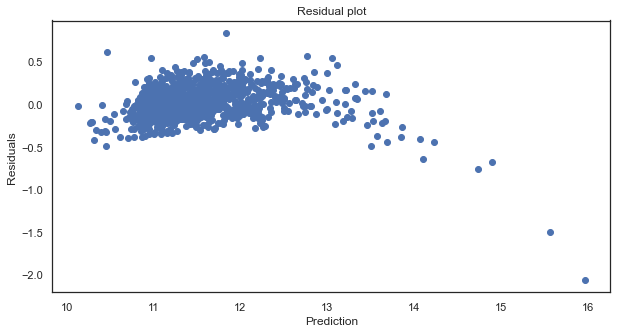

In [83]:
# Defining Graph size
plt.figure(figsize=(10,5))

# Plot your predicted values on the x-axis, and your residuals on the y-axis on Residue Plot
plt.scatter(y_pred, (y_test - y_pred))
plt.title("Residual plot")
plt.xlabel("Prediction")
plt.ylabel("Residuals")

## Section 6.2: QQ Plot

Text(0.5, 1.0, 'Normal Q-Q plot')

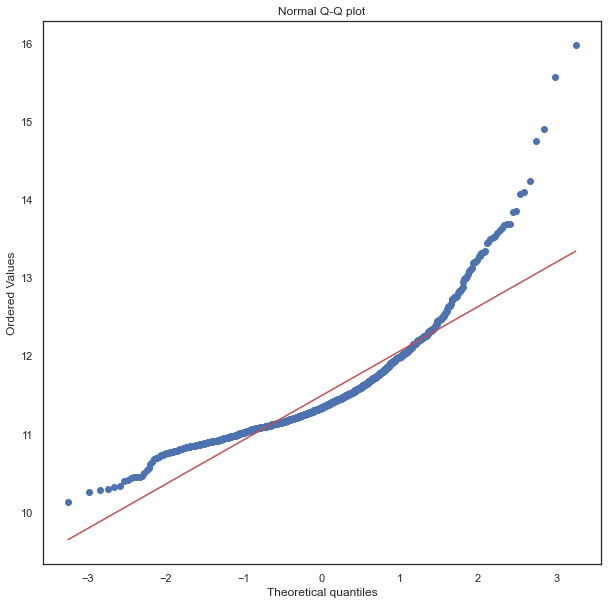

In [84]:
# diagnose/inspect residual normality using QQplot:
plt.figure(figsize=(10,10))
stats.probplot(y_pred, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

# Section 7: Advanced Regression Boosting Technique using XGBOOST (Gradient Boosted Trees)

In [2]:
import xgboost as xgb

In [86]:
df_finalised.head()

PRICE_LOG  MILEAGE_KM      ARF  COE_LISTED  DAYS_OF_COE_LEFT  NO_OF_OWNERS  \
0  11.461622     45000.0  31850.0     46229.0            2089.0           3.0   
1  10.874266     62316.0  13225.0     50101.0            2171.0           1.0   
2  11.205041    147000.0  32750.0     59889.0            1688.0           1.0   
3  11.405340     72000.0  10584.0     47020.0            1891.0           2.0   
4  11.195471     76022.0  19146.0     47604.0            1837.0           1.0   

   Alfa Romeo  Alpine  Aston Martin  Audi  ...  Z4 sDrive20i  \
0           0       0             0     0  ...             0   
1           0       0             0     0  ...             0   
2           0       0             0     0  ...             0   
3           0       0             0     0  ...             0   
4           0       0             0     0  ...             0   

   Z4 sDrive20i M-Sport  Z4 sDrive28i  Z4 sDrive35is M-Sport  Zafira Tourer  \
0                     0             0                      0              0   
1                     0             0                      0              0   
2                     0             0                      0              0   
3                     0             0                      0              0   
4                     0             0                      0              0   

   i3 Electric Range Extender Suite  i30 1.4A T-GDi DCT Turbo  \
0                                 0                         0   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   

   i30 1.6A Sunroof  i30 Wagon 1.4A T-GDi DCT Turbo  i8  
0                 0                               0   0  
1                 0                               0   0  
2                 0                               0   0  
3                 0                               0   0  
4                 0                               0   0  

[5 rows x 1498 columns]

In [87]:
from sklearn.model_selection import train_test_split

X = df_finalised.drop(['PRICE_LOG'], axis =1)
y = df_finalised['PRICE_LOG']

# hold out 20% of the data for final testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state=20)

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from time import time

#The functions RandomizedSearchCV and GridSearchCV functions from sklearn.model_selection are used for hyperparameters optimization

In [89]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.5f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

    return

## Section 7.1 Step 1: Tune max_depth and min_child_weight

In [91]:
from scipy.stats import randint as sp_randint

#The parameters max_depth and min_child_weight are the number of layers of decision trees used 
# and the minimum sum of instance weight in a tree’s child, respectively.

fixed_params_rd1 = {
    'n_estimators': 500
}

# specify parameters and distributions to sample from
cv_params_rd1 = {"max_depth": sp_randint(3,11),
                 "min_child_weight": sp_randint(1,6)}

# randomized search
n_iter_search = 25
optimized_XGB = RandomizedSearchCV(xgb.XGBRegressor(**fixed_params_rd1),
                               cv_params_rd1,
                               scoring = 'neg_mean_squared_error',
                               cv = 5,
                               n_iter = n_iter_search,
                               n_jobs = -1,
                               verbose = 3, random_state =20)



start = time()

optimized_XGB.fit(X_train, y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(optimized_XGB.cv_results_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 35.1min finished


RandomizedSearchCV took 2127.17 seconds for 25 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.00864 (std: 0.00082)
Parameters: {'max_depth': 6, 'min_child_weight': 1}

Model with rank: 2
Mean validation score: -0.00874 (std: 0.00092)
Parameters: {'max_depth': 8, 'min_child_weight': 1}

Model with rank: 3
Mean validation score: -0.00874 (std: 0.00077)
Parameters: {'max_depth': 5, 'min_child_weight': 2}

Model with rank: 3
Mean validation score: -0.00874 (std: 0.00077)
Parameters: {'max_depth': 5, 'min_child_weight': 2}



In [95]:
score = optimized_XGB.best_estimator_.score(X_val, y_val)
print("Score on the validation set (~0.20 of training set) R^2 = %.5f" % score)

Score on the validation set (~0.20 of training set) R^2 = 0.97727


## Section 7.2 Step 2: Tune gamma

In [98]:
# The hyperparameter gamma is the minimum loss reduction required to create a further partition. 
#This can also be thought of as information gain required from a certain split in order to make that split.

from scipy.stats import uniform as sp_uniform

fixed_params_rd2 = {
    'n_estimators': 500,
    "max_depth": 6,
    "min_child_weight": 1
}

# specify parameters and distributions to sample from
rvs = sp_uniform(0.,0.3)
cv_params_rd2 = {"gamma": rvs}

# randomized search
n_iter_search = 15
optimized_XGB = RandomizedSearchCV(xgb.XGBRegressor(**fixed_params_rd2),
                               cv_params_rd2,
                               scoring = 'neg_mean_squared_error',
                               cv = 5,
                               n_iter = n_iter_search,
                               n_jobs = -1,
                               verbose = 3, random_state =20)


start = time()

optimized_XGB.fit(X_train, y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 20.3min finished


RandomizedSearchCV took 1243.93 seconds for 15 candidates parameter settings.


In [99]:
report(optimized_XGB.cv_results_)
score = optimized_XGB.best_estimator_.score(X_val, y_val)
print("Score on the validation set (~0.20 of training set) R^2 = %.5f" % score)

Model with rank: 1
Mean validation score: -0.00956 (std: 0.00064)
Parameters: {'gamma': 0.010766875685055988}

Model with rank: 2
Mean validation score: -0.01140 (std: 0.00075)
Parameters: {'gamma': 0.05815506536488449}

Model with rank: 3
Mean validation score: -0.01171 (std: 0.00071)
Parameters: {'gamma': 0.08169492061997517}

Score on the validation set (~0.20 of training set) R^2 = 0.97382


## Section 7.3 Step 3: Tune subsample and colsample_bytree

In [101]:
# The hyperparameters subsample and colsample_bytree are the subsample ratio of training data and the subsample ratio of columns when constructing a new tree, respectively. 
# The first parameter is to prevent overfitting to the training data.

fixed_params_rd3 = {
    'n_estimators': 500,
    "max_depth": 6,
    "min_child_weight": 1, 
    'gamma': 0.010766875685055988
}

# specify parameters and distributions to sample from
rvs_1 = sp_uniform(0.6,0.4)
rvs_2 = sp_uniform(0.6,0.4)
cv_params_rd3 = {"subsample": rvs_1,
                 "colsample_bytree": rvs_2}

# randomized search
n_iter_search = 50
optimized_XGB = RandomizedSearchCV(xgb.XGBRegressor(**fixed_params_rd3),
                               cv_params_rd3,
                               scoring = 'neg_mean_squared_error',
                               cv = 5,
                               n_iter = n_iter_search,
                               n_jobs = -1,
                               verbose = 3, random_state =20)


start = time()

optimized_XGB.fit(X_train, y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(optimized_XGB.cv_results_)
print("Score on the validation set (~0.20 of training set) R^2 = %.5f" % score)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 64.2min finished


RandomizedSearchCV took 3876.31 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.00878 (std: 0.00109)
Parameters: {'colsample_bytree': 0.7274318238319208, 'subsample': 0.7579372883433709}

Model with rank: 2
Mean validation score: -0.00893 (std: 0.00085)
Parameters: {'colsample_bytree': 0.8109350418939539, 'subsample': 0.8637267822322278}

Model with rank: 3
Mean validation score: -0.00898 (std: 0.00094)
Parameters: {'colsample_bytree': 0.9658551924009275, 'subsample': 0.7136100023680834}

Score on the validation set (~0.20 of training set) R^2 = 0.97382


In [102]:
score = optimized_XGB.best_estimator_.score(X_val, y_val)
print("Score on the validation set (~0.20 of training set) R^2 = %.5f" % score)

Score on the validation set (~0.20 of training set) R^2 = 0.97602


## Section 7.4 Step 4: Tune regularization parameters

In [105]:
#The hyperparameters reg_alpha and reg_lambda are the L1 and L2 regularization terms, respectively. 
#The function GridSearchCV is used due to the scale desired on the L1 term reg_alpha. It would be difficult to randomly sample and hit the desired scales to test for this hyperparameter.

fixed_params_rd4 = {
    'n_estimators': 500,
    'subsample': 0.7579372883433709,
    'colsample_bytree': 0.7274318238319208,
    "max_depth": 6,
    "min_child_weight": 1,
    'gamma': 0.010766875685055988
}

# specify parameters to search across
cv_params_rd4 = {'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
                 'reg_lambda': [0.7, 0.8, 0.9, 1.,1.1]}

# grid search
optimized_XGB = GridSearchCV(xgb.XGBRegressor(**fixed_params_rd4),
                         cv_params_rd4,
                         scoring = 'neg_mean_squared_error',
                         cv = 5,
                         n_jobs = -1,
                         verbose = 3)


start = time()

optimized_XGB.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), 25)) #25 = number of reg_alpha * number of reg_lambda entries

report(optimized_XGB.cv_results_)

score = optimized_XGB.best_estimator_.score(X_val, y_val)
print("Score on the validation set (~0.20 of training set) = %.5f" % score)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 30.0min finished


GridSearchCV took 1819.29 seconds for 25 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.00878 (std: 0.00109)
Parameters: {'reg_alpha': 0, 'reg_lambda': 1.0}

Model with rank: 2
Mean validation score: -0.00887 (std: 0.00094)
Parameters: {'reg_alpha': 0.05, 'reg_lambda': 1.0}

Model with rank: 3
Mean validation score: -0.00892 (std: 0.00068)
Parameters: {'reg_alpha': 0, 'reg_lambda': 0.9}

Score on the validation set (~0.20 of training set) = 0.97602


Resulting {'reg_alpha': 0, 'reg_lambda': 1.0} is same as default values, nothing to set here.

## Section 7.5 Step 5: Tune learning_rate

In [109]:
fixed_params_rd5 = {
    'n_estimators': 500,
    'subsample': 0.7579372883433709,
    'colsample_bytree': 0.7274318238319208,
    "max_depth": 6,
    "min_child_weight": 1,
    'gamma': 0.010766875685055988   
}

# specify parameters to search across
rvs = sp_uniform(.00001, 0.4)
cv_params_rd5 = {'learning_rate': rvs}

# randomized search
n_iter_search = 20
optimized_XGB = RandomizedSearchCV(xgb.XGBRegressor(**fixed_params_rd5),
                               cv_params_rd5,
                               scoring = 'neg_mean_squared_error',
                               cv = 5,
                               n_iter = n_iter_search,
                               n_jobs = -1,
                               verbose = 3, random_state = 20)


start = time()

optimized_XGB.fit(X_train, y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

report(optimized_XGB.cv_results_)


score = optimized_XGB.best_estimator_.score(X_val, y_val)
print("Score on the validation set (~0.20 of training set) = %.5f" % score)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 50.2min finished


RandomizedSearchCV took 3034.01 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.00814 (std: 0.00087)
Parameters: {'learning_rate': 0.15148237680216328}

Model with rank: 2
Mean validation score: -0.00818 (std: 0.00099)
Parameters: {'learning_rate': 0.10893656082663357}

Model with rank: 3
Mean validation score: -0.00818 (std: 0.00107)
Parameters: {'learning_rate': 0.0956972864798438}

Score on the validation set (~0.20 of training set) = 0.97697


## Section 7.6 Step 6: Tune n_estimators

In [111]:
fixed_params_rd6 = {
    'learning_rate': 0.15148237680216328,
    'subsample': 0.7579372883433709,
    'colsample_bytree': 0.7274318238319208,
    "max_depth": 6,
    "min_child_weight": 1,
    'gamma': 0.010766875685055988  
}

# specify parameters to search across
cv_params_rd6 = {'n_estimators':[10, 100, 500, 1000, 5000]}

# grid search
optimized_XGB = GridSearchCV(xgb.XGBRegressor(**fixed_params_rd6),
                         cv_params_rd6,
                         scoring = 'neg_mean_squared_error',
                         cv = 5,
                         n_jobs = -1,
                         verbose = 3)


start = time()

optimized_XGB.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), 5)) 

report(optimized_XGB.cv_results_)

score = optimized_XGB.best_estimator_.score(X_val, y_val)
print("Score on the validation set (~0.20 of training set) = %.5f" % score)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  5.3min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 15.4min finished


GridSearchCV took 1111.30 seconds for 5 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.00792 (std: 0.00086)
Parameters: {'n_estimators': 5000}

Model with rank: 2
Mean validation score: -0.00803 (std: 0.00086)
Parameters: {'n_estimators': 1000}

Model with rank: 3
Mean validation score: -0.00814 (std: 0.00087)
Parameters: {'n_estimators': 500}

Score on the validation set (~0.20 of training set) = 0.97764


# Section 8: Final Model Evaluation and Validation

In [6]:
df_finalised = pd.read_csv('df_finalised.csv', index_col = 0)

## Section 8.1: Testing model on 20% DataSet

In [7]:
from time import time
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold  #Kfold will allow you to do cross validation

X = df_finalised.drop(['PRICE_LOG'], axis =1)
y = df_finalised['PRICE_LOG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=20)

In [21]:
final_xgb = xgb.XGBRegressor(learning_rate= 0.15148237680216328,
    subsample= 0.7579372883433709,
    colsample_bytree= 0.7274318238319208,
    max_depth= 6,
    min_child_weight= 1,
    gamma= 0.010766875685055988,
    n_estimators= 5000,
    random_state= 20)
start = time()
final_xgb.fit(X_train, y_train)
print(final_xgb.get_params)
print("\nFitting and Training took %.2f seconds" % (time() - start)) 

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7274318238319208,
             gamma=0.010766875685055988, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.15148237680216328,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, random_state=20, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7579372883433709,
             tree_method='exact', validate_parameters=1, verbosity=None)>

Fitting and Training took 241.93 seconds


In [22]:
from sklearn import metrics
y_pred = final_xgb.predict(X_test)
print('r2 score:', metrics.r2_score(y_test, y_pred))
print('rmse:', metrics.mean_squared_error(y_test, y_pred, squared = False))
print('implies an error distance between actual pricing and predicted pricing of:', np.exp(metrics.mean_squared_error(y_test, y_pred, squared = False)))

r2 score: 0.9821370692547408
rmse: 0.08552430097052997
implies an error distance between actual pricing and predicted pricing of: 1.0892880317787947


### Section 8.1.1 Saving final model for API wrapper service

In [23]:
final_xgb.save_model('xg_final.model')

# Saving columns of features used as a skeleton dataframe for API wrapper prediction 
df_skeleton = pd.DataFrame(columns = X_train.columns)
df_skeleton.to_csv('df_skeleton_1_4.csv')

## Section 8.2: Model Validation

In [4]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 7),
                        fname="output.png"):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose = 3)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.savefig(fname)
    return plt

[learning_curve] Training set sizes: [ 380  950 1520 2090 2660 3230 3801]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 out of 140 | elapsed: 42.3min remaining: 83.7min
[Parallel(n_jobs=-1)]: Done  94 out of 140 | elapsed: 81.3min remaining: 39.8min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 117.9min finished


<module 'matplotlib.pyplot' from 'C:\\Users\\user\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

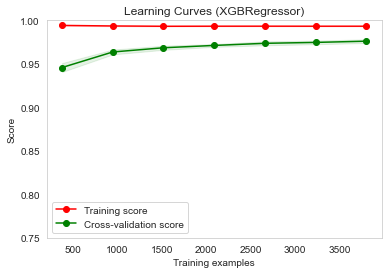

In [6]:
title = "Learning Curves (XGBRegressor)"
# Cross validation with 20 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=20)
estimator = xgb.XGBRegressor(learning_rate= 0.15148237680216328,
                            subsample= 0.7579372883433709,
                            colsample_bytree= 0.7274318238319208,
                            max_depth= 6,
                            min_child_weight= 1,
                            gamma= 0.010766875685055988,
                            n_estimators= 5000,
                            random_state= 20,
                            tree_method= 'gpu_hist')

plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.75, 1.0), cv=cv, n_jobs=-1, fname="xgb_cv.png")

The plot above shows there is a always a gap between the 2 curves with the cross-validation scores always below the training scores at every point. This implies that the model cannot generalise very well with new/unseen data, the model is overfitting, introducing high variance to the test prediction results.  

The high training score of ~0.98 which persists from the start when even the number of training examples are low, implies that the amount of training examples (data) is too small from the start, thus giving unrealistically low amount of errors and very high scores.

In [85]:
import xgboost as xgb
final_xgb = xgb.XGBRegressor()
final_xgb.load_model('xg_final.model')

***Analysis of Prediction Errors***

In [86]:
y_pred = final_xgb.predict(X)
# convert to price
y_pred = np.exp(y_pred)

# create predicted value column and compare to original calculate error
df_clean_compare = df_clean.copy()
df_clean_compare['Y_PREDICT'] = y_pred
df_clean_compare['ERROR'] = df_clean_compare['Y_PREDICT']-df_clean_compare['PRICE']
df_clean_compare

BRAND                       MODEL_SUBMODEL     PRICE  \
0            Jaguar              XE Diesel 2.0A Prestige   94999.0   
1        Mitsubishi                       Lancer EX 1.6A   52800.0   
2             Honda  Odyssey 2.4A EXV-S Navi Res Sunroof   73500.0   
3             Honda                         Vezel 1.5A X   89800.0   
4            Subaru               Forester 2.0XT Sunroof   72800.0   
...             ...                                  ...       ...   
6947           Opel                     Astra 1.4A Turbo   61800.0   
6948         Toyota                  Camry Hybrid 2.5A G  113800.0   
6949  Mercedes-Benz  C-Class C200 Mild Hybrid Avantgarde  168888.0   
6950          Honda           Vezel 1.5A X Honda Sensing   71800.0   
6952         Subaru     Forester 2.0i-S EyeSight Sunroof  108000.0   

      MILEAGE_KM      ARF  COE_LISTED  DAYS_OF_COE_LEFT  NO_OF_OWNERS  \
0        45000.0  31850.0     46229.0            2089.0           3.0   
1        62316.0  13225.0     50101.0            2171.0           1.0   
2       147000.0  32750.0     59889.0            1688.0           1.0   
3        72000.0  10584.0     47020.0            1891.0           2.0   
4        76022.0  19146.0     47604.0            1837.0           1.0   
...          ...      ...         ...               ...           ...   
6947     62000.0  15700.0     53300.0            2257.0           1.0   
6948     13903.0  36714.0     42564.0            2992.0           1.0   
6949      4800.0  53152.0     41001.0            3143.0           1.0   
6950     41724.0  11630.0     42339.0            2469.0           1.0   
6952     25000.0  17902.0     38602.0            3084.0           1.0   

          Y_PREDICT         ERROR  
0      87761.453125  -7237.546875  
1      55860.593750   3060.593750  
2      75517.343750   2017.343750  
3      73850.414062 -15949.585938  
4      71511.273438  -1288.726562  
...             ...           ...  
6947   62387.578125    587.578125  
6948  117279.875000   3479.875000  
6949  169724.718750    836.718750  
6950   70692.296875  -1107.703125  
6952  104768.984375  -3231.015625  

[5940 rows x 10 columns]

In [87]:
df_clean_compare.to_csv('df_clean_compare.csv')

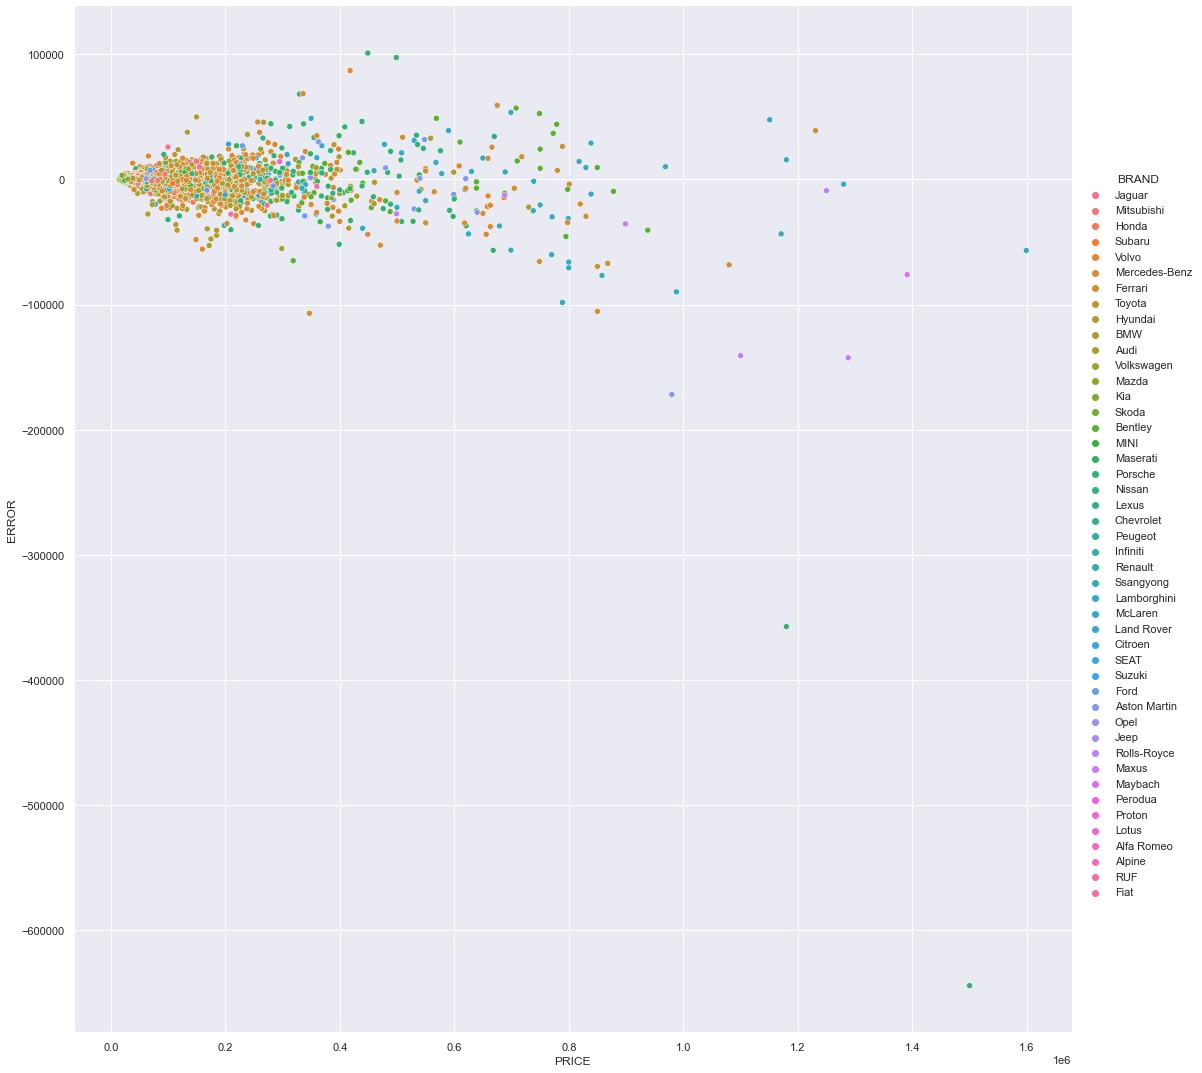

In [124]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
g= sns.relplot(x="PRICE", y="ERROR", hue="BRAND", data=df_clean_compare, height = 15)